In [1]:
import os

dataset_path = './JDDB_repo_2A_5k'
file_list = os.listdir(dataset_path)
print(file_list[:10])

['35956.hdf5', '35957.hdf5', '35958.hdf5', '35959.hdf5', '35960.hdf5', '35961.hdf5', '35962.hdf5', '35963.hdf5', '35964.hdf5', '35965.hdf5']


{'DS-SXR-SXA:SX20', 'DS-EMD-MP:NPOL-07', 'DS-BM-AB:BOLD01', 'DS-EMD-MP:MPOL-05', 'DS-SXR-SXA:SX19', 'DS-SXR-SXA:SX03', 'CCO-LFB:LFBBT', 'DS-SXR-SXA:SX18', 'DS-BM-AB:BOLD02', 'DS-EMD-MP:NPOL-06', 'DS-SXR-SXA:SX08', 'DS-EMD-MP:MPOL-06', 'DS-EMD-MP:NPOL-09', 'DS-EMD-MP:MPOL-10', 'DS-BM-AB:BOLD06', 'DS-SXR-SXA:SX12', 'DS-BM-AB:BOLD15', 'CCO-LFB:LFBBV', 'DS-EMD-MP:NPOL-02', 'DS-EMD-MP:MPOL-04', 'DS-BM-AB:BOLD04', 'DS-EMD-MP:MPOL-08', 'DS-BM-AB:BOLD07', 'DS-EMD-MP:NPOL-03', 'DS-BM-AB:BOLD11', 'DS-EMD-ROG:VL-FILTER', 'DS-EMD-MP:MPOL-11', 'DS-SXR-SXA:SX10', 'DS-SXR-SXA:SX17', 'DS-SXR-SXA:SX09', 'DS-SXR-SXA:SX01', 'DS-SXR-SXA:SX14', 'RotatingModeProxy', 'DS-EMD-MP:NPOL-01', 'DS-BM-AB:BOLD13', 'DS-SXR-SXA:SX06', 'DS-BM-AB:BOLD08', 'DS-EMD-MP:MPOL-12', 'RadiatedFraction', 'CCO-DF:GASFBOUT', 'DS-EMD-MP:NPOL-04', 'CCO-LFB:LFEX-IP', 'CCO-LFB:LFDH', 'DS-BM-AB:BOLD16', 'CCO-LFB:LFBBOH', 'DS-EMD-MP:MPOL-15', 'DS-EMD-MP:NPOL-05', 'CCO-LFB:LFBMP2', 'DS-SXR-SXA:SX07', 'DS-TMP:PUFFCTRL', 'DS-SXR-SXA:SX02',

Text(0.5, 0, 'Time(s)')

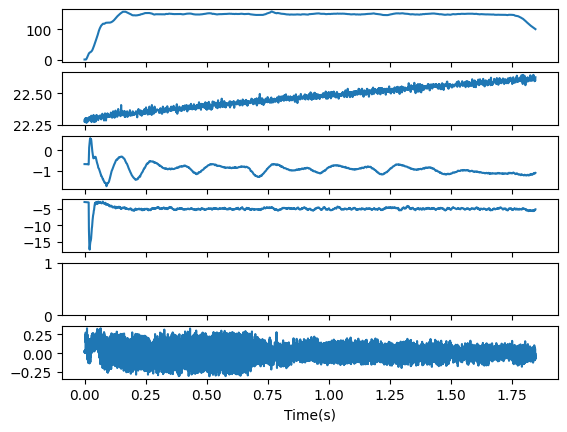

In [3]:
from jddb.file_repo import FileRepo
from jddb.processor import Shot
import numpy as np
import matplotlib.pyplot as plt

# load file repo
file_repo = FileRepo(r"./JDDB_repo_2A_5k")

# select a shot id in the file repo, see which signals are given in this shot
shot_list = file_repo.get_all_shots()
shot_id = shot_list[16]
example_shot = Shot(shot_id, file_repo)
print(example_shot.tags)

# plot some basic plasma parameters
# CCO-LFB:LFEX-IP     |      plasma current(kA)
# CCO-LFB:LFBBT       |      current in toroidal magnetic field coild(kA), can be conveted into field intensity by timing 0.0622T/kA
# CCO-LFB:LFDH        |      horizontal displacement of plasma (i.e.)
# CCO-LFB:LFDV        |      vertical displacement of plasma (i.e.)
# CO-DF:DENSITY1      |      plasma density(10e19/m^3)
# DS-EMD-MP:MPOL-04     |      magnetic perturbation measured by Mirnov porbe
plot_tags = ["CCO-LFB:LFEX-IP", "CCO-LFB:LFBBT", "CCO-LFB:LFDH", "CCO-LFB:LFDV", "CCO-DF:DENSITY1", "DS-EMD-MP:MPOL-04"]
f, axs = plt.subplots(nrows=6, ncols=1, sharex=True)
axs = np.reshape(axs, -1)
for i, tag in enumerate(plot_tags):
    if example_shot.labels[tag] == 1:
        data = example_shot.get_signal(tag)
        axs[i].plot(data.time, data.data)
axs[i].set_xlabel('Time(s)')


## Data cleaning

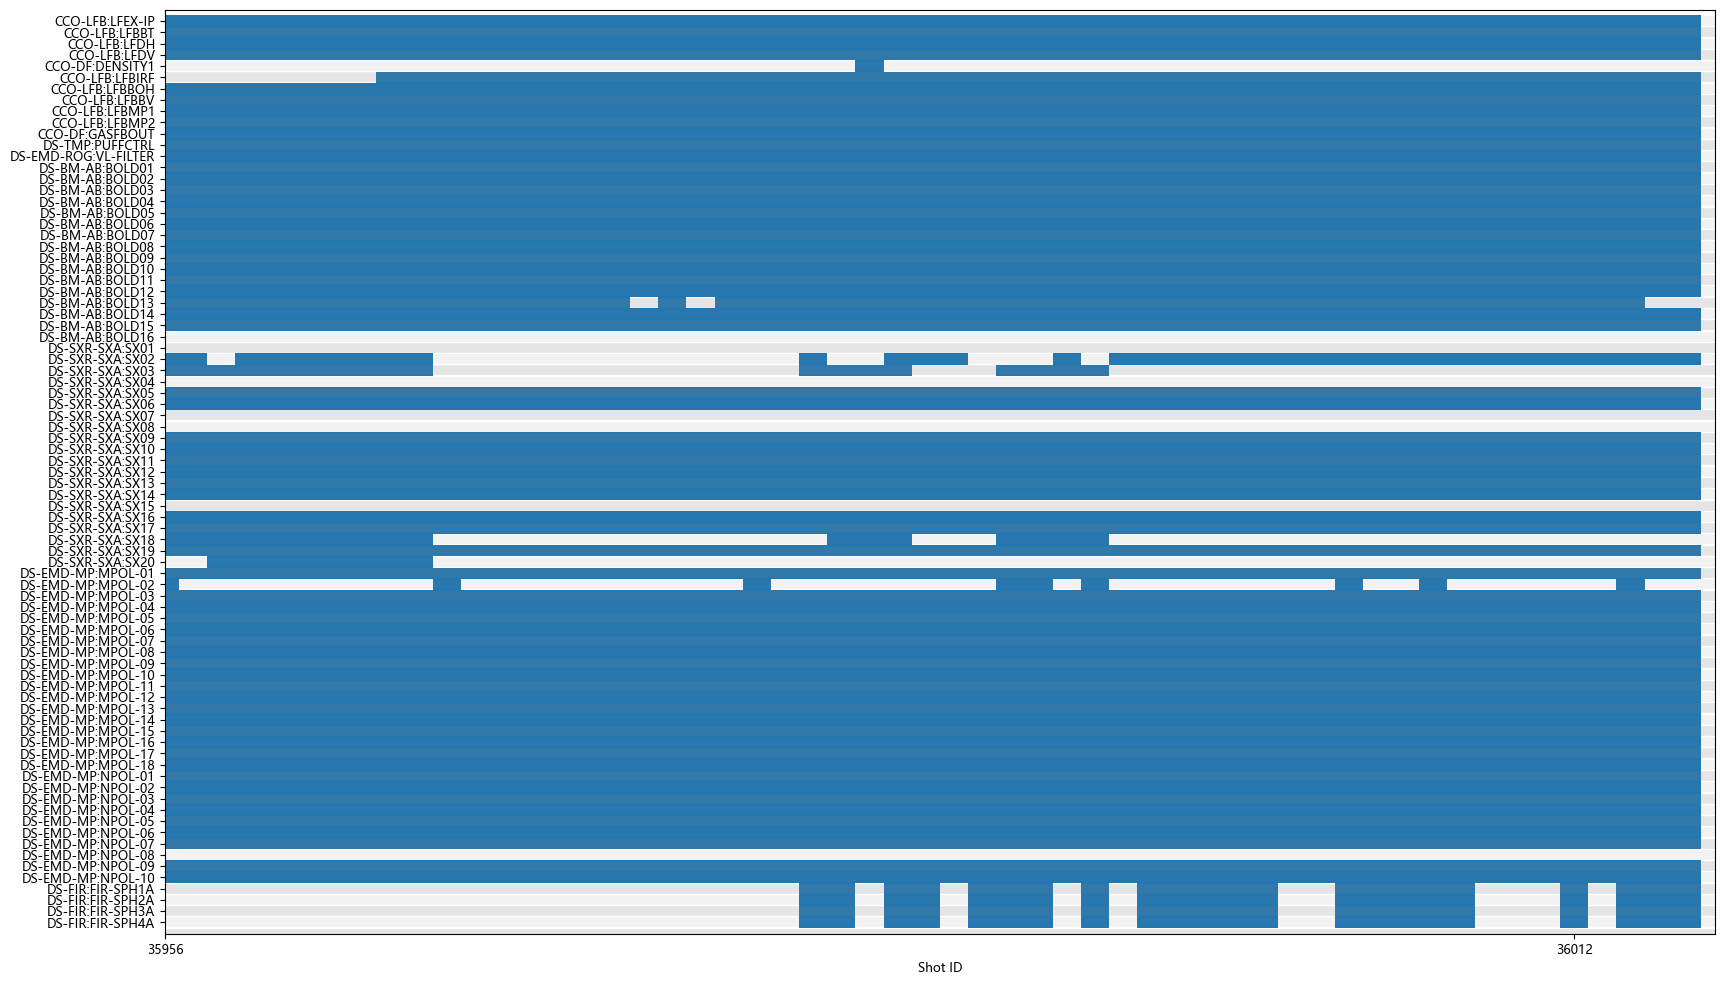

In [4]:
# set a tag list to check health
tags = ["CCO-LFB:LFEX-IP", "CCO-LFB:LFBBT", "CCO-LFB:LFDH", "CCO-LFB:LFDV", "CCO-DF:DENSITY1", "CCO-LFB:LFBIRF",
        "CCO-LFB:LFBBOH", "CCO-LFB:LFBBV", "CCO-LFB:LFBMP1", "CCO-LFB:LFBMP2", "CCO-DF:GASFBOUT", "DS-TMP:PUFFCTRL",
        "DS-EMD-ROG:VL-FILTER"]
tags += ["DS-BM-AB:BOLD%02d" % channel_id for channel_id in range(1, 17)]
tags += ["DS-SXR-SXA:SX%02d" % channel_id for channel_id in range(1, 21)]
tags += ["DS-EMD-MP:MPOL-%02d" % channel_id for channel_id in range(1, 19)]
tags += ["DS-EMD-MP:NPOL-%02d" % channel_id for channel_id in range(1, 11)]
tags += ["DS-FIR:FIR-SPH%1dA" % channel_id for channel_id in range(1, 5)]

# collect the validity flag of each tag for each shot in to an aray
valid_array = np.zeros([len(tags), len(shot_list)])
for i, shot_id in enumerate(shot_list):
    shot_tags = file_repo.get_tag_list(shot_id)
    shot_labels = file_repo.read_labels(shot_id)
    for j, tag in enumerate(tags):
        if tag in shot_labels:
            valid_array[j, i] = shot_labels[tag]

# plot the data health figure
font = {'family': 'Microsoft YaHei',
        'size': '9'}
plt.rc('font', **font)
f = plt.figure(figsize=[20, 12])
ax = f.add_subplot(111)
for i, tag in enumerate(tags):
    for j, shot_id in enumerate(shot_list):
        if valid_array[i, j] == 1:
            rect = plt.Rectangle((j-0.5, len(tags)-i-1.5), 1, 1)
            ax.add_patch(rect)
ax.set_xlabel("Shot ID")
ax.set_xlim([0, len(shot_list)])
ax.set_xticks(np.arange(0, len(shot_list), 50))
ax.set_xticklabels(np.array(shot_list)[np.arange(0, len(shot_list), 50)])
ax.set_ylim([-1, len(tags)])
ax.set_yticks(np.arange(len(tags)))
ax.set_yticklabels(tags[::-1])
for i in range(-1, len(tags)):
    ax.plot(ax.get_xlim(), [i, i], color='gray', linewidth=7, alpha=(np.mod(i, 2)+1)*0.1)


In [6]:
# Two pairs of Mirnov Probes, one poloidal symmetrical pair and one toroidal symmetrical pair
Mir = ["DS-EMD-MP:MPOL-04", "DS-EMD-MP:MPOL-13", "DS-EMD-MP:NPOL-04", "DS-EMD-MP:NPOL-09"]
# One channel for core region and one channel for edge region
sxr = ["DS-SXR-SXA:SX05", "DS-SXR-SXA:SX10"]
# Basic plasma and tokamak parameters
basic = ["CCO-LFB:LFEX-IP", "CCO-LFB:LFBBT", "CCO-LFB:LFDH", "CCO-LFB:LFDV", "CCO-LFB:LFBIRF", "CCO-LFB:LFBBOH", 
         "CCO-LFB:LFBBV", "CCO-LFB:LFBMP1", "CCO-LFB:LFBMP2", "CCO-DF:GASFBOUT", "DS-TMP:PUFFCTRL", "DS-EMD-ROG:VL-FILTER"]
# Density array
density = ["DS-FIR:FIR-SPH%1dA" % channel_id for channel_id in range(1, 5)]
# Bolometer array, only core channels selected according to the data completeness
AXUV = ["DS-BM-AB:BOLD09", "DS-BM-AB:BOLD10", "DS-BM-AB:BOLD11"]

## Feature extraction and data labeling

In [7]:
from jddb.processor import ShotSet
from jddb.processor.basic_processors import TrimProcessor
from basic_processor import SliceProcessor, FFTProcessor, find_tags, AlarmTag



source_file_repo = FileRepo(r"./JDDB_repo_2A_5k")
processed_file_repo = FileRepo(r"./JDDB_repo_2A_processed")
# create a valid shot set with a file, the valid shots should contain target tags and enough flattop time.
source_shotset = ShotSet(source_file_repo)
shot_list = source_shotset.shot_list
# Define the target tags which contain signals for process
targ_tags = basic + density + Mir + AXUV + sxr
valid_shots = []  # Initialize an empty list to store valid shots
for shot in shot_list:
    all_tags = list(source_shotset.get_shot(shot).tags)
    last_time = list(source_file_repo.read_labels(shot, ['DownTime']).values())
    # Check if all target tags are present in the shot's tags and last_time of shot is greater than 0.2s
    if all(tag in all_tags for tag in targ_tags) & (last_time[0] > 0.2):
        valid_shots.append(shot)

processed_shotset = ShotSet(source_file_repo, valid_shots)  # Create a new ShotSet object using the valid shots
# 1. FFT processing for max frequency and amplitude of mirnov signals
for tag_index in range(len(Mir)):
    # %%
    # slicing
    processed_shotset = processed_shotset.process(
        processor=SliceProcessor(window_length=50, overlap=0.9),
        input_tags=[Mir[tag_index]],
        output_tags=["sliced_MA_{}".format(tag_index)],
        save_repo=processed_file_repo,
        processes=4)
    # %%
    # fft MA
    processed_shotset = processed_shotset.process(
        processor=FFTProcessor(),
        input_tags=["sliced_MA_{}".format(tag_index)],
        output_tags=[["fft_amp_{}".format(tag_index), "fft_fre_{}".format(tag_index)]],
        save_repo=processed_file_repo,
        processes=4)
    print('FFT %s finished' % Mir[tag_index])

# 2. remove redundant tags and keep tags for model training
shot_list = processed_shotset.shot_list
all_tags = list(processed_shotset.get_shot(shot_list[0]).tags)
fft_tag = find_tags('fft_', all_tags)
fir_tag = find_tags('resampled_fir_', all_tags)
keep_tags = basic + fir_tag + fft_tag +sxr + AXUV
processed_shotset = processed_shotset.remove_signal(tags=keep_tags, keep=True,
                                                    save_repo=processed_file_repo)
print('Remove redundant tags, finished')

# 3. trim  signals into same length
all_tags = list(processed_shotset.get_shot(shot_list[0]).tags)
processed_shotset = processed_shotset.process(
    TrimProcessor(),
    input_tags=[all_tags],
    output_tags=[all_tags],
    save_repo=processed_file_repo,
    processes=4)
print('Trim  signals into same length, finished')

# 4. add disruption labels for each time point as a signal called alarm_tag
processed_shotset = processed_shotset.process(
    processor=AlarmTag(lead_time=0.1, disruption_label="IsDisrupt", downtime_label="DownTime"),
    input_tags=["CCO-LFB:LFEX-IP"],
    output_tags=["alarm_tag"],
    save_repo=processed_file_repo,
    processes=4)
print('Add disruption labels, finished')


FFT DS-EMD-MP:MPOL-04 finished
FFT DS-EMD-MP:MPOL-13 finished
FFT DS-EMD-MP:NPOL-04 finished
FFT DS-EMD-MP:NPOL-09 finished
Remove redundant tags, finished
Trim  signals into same length, finished
Add disruption labels, finished


# XGBOOST

In [21]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from jddb.performance import Result, Report
from jddb.file_repo import FileRepo

# %% define function to build model specific data
def matrix_build(shot_list, file_repo, tags):
    """
    get x and y from file_repo by shots and tags
    Args:
        shot_list: shots for data matrix
        file_repo:
        tags: tags from file_repo

    Returns: matrix of x and y
    """
    x_set = np.empty([0, len(tags) - 1])
    y_set = np.empty([0])
    for shot in shot_list:
        shot = int(shot)
        x_data = file_repo.read_data(shot, tags)
        y_data = file_repo.read_data(shot, ['alarm_tag'])
        x_data.pop('alarm_tag', None)
        res = np.array(list(x_data.values())).T
        res_y = np.array(list(y_data.values())).T.flatten()
        x_set = np.append(x_set, res, axis=0)
        y_set = np.append(y_set, res_y, axis=0)
    return x_set, y_set

# init FileRepo
test_file_repo = FileRepo(r"./JDDB_repo_2A_processed")
test_shot_list = test_file_repo.get_all_shots()
print(len(test_shot_list))
tag_list = test_file_repo.get_tag_list(test_shot_list[0])

# disruption tag for dataset split
is_disrupt = []
for shot in test_shot_list:
    dis_label = test_file_repo.read_labels(shot, ['IsDisrupt'])
    is_disrupt.append(dis_label['IsDisrupt'])

# train test split on shot not sample according to whether shots are disruption
# set test_size=0.5 to get 50% shots as test set
train_shots, test_shots, _, _ = train_test_split(test_shot_list, is_disrupt, test_size=0.3, random_state=1, shuffle=True, stratify=is_disrupt)

# create x and y matrix for ML models
X_train, y_train = matrix_build(train_shots, test_file_repo, tag_list)
X_test, y_test = matrix_build(test_shots, test_file_repo, tag_list)

# Initialize XGBoost classifier
clf = XGBClassifier(objective='binary:logistic', random_state=0, n_jobs=-1)

# Measure time for training
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Make predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))


22
Training time: 0.15 seconds
Confusion Matrix:
[[12129     0]
 [  116    65]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     12129
         1.0       1.00      0.36      0.53       181

    accuracy                           0.99     12310
   macro avg       1.00      0.68      0.76     12310
weighted avg       0.99      0.99      0.99     12310


ROC AUC Score:
0.808595353176192


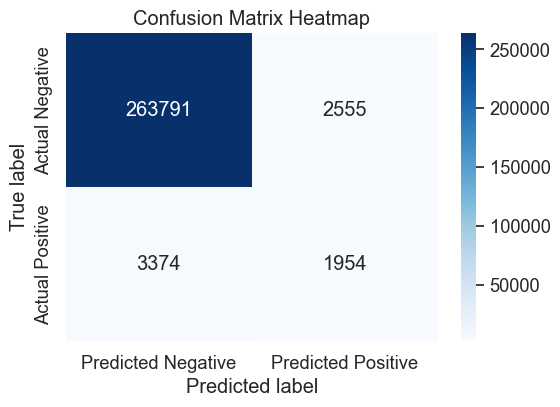

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming the confusion matrix and other metrics are already computed
conf_matrix = np.array([[263791, 2555],
                        [3374, 1954]])

# Plotting confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()

# XGBOOST (Tomek Link)

In [70]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.under_sampling import TomekLinks
from jddb.performance import Result, Report
from jddb.file_repo import FileRepo

# Define function to build model specific data
def matrix_build(shot_list, file_repo, tags):
    x_set = np.empty([0, len(tags) - 1])
    y_set = np.empty([0])
    for shot in shot_list:
        shot = int(shot)
        x_data = file_repo.read_data(shot, tags)
        y_data = file_repo.read_data(shot, ['alarm_tag'])
        x_data.pop('alarm_tag', None)
        res = np.array(list(x_data.values())).T
        res_y = np.array(list(y_data.values())).T.flatten()
        x_set = np.append(x_set, res, axis=0)
        y_set = np.append(y_set, res_y, axis=0)
    return x_set, y_set

# Initialize FileRepo
test_file_repo = FileRepo(r"./JDDB_repo_2A_processed")
test_shot_list = test_file_repo.get_all_shots()
print(len(test_shot_list))
tag_list = test_file_repo.get_tag_list(test_shot_list[0])

# Disruption tag for dataset split
is_disrupt = []
for shot in test_shot_list:
    dis_label = test_file_repo.read_labels(shot, ['IsDisrupt'])
    is_disrupt.append(dis_label['IsDisrupt'])

# Train-test split on shot, not sample, according to whether shots are disruptions
# Set test_size=0.5 to get 50% shots as the test set
train_shots, test_shots, _, _ = train_test_split(
    test_shot_list, is_disrupt, test_size=0.5,
    random_state=1, shuffle=True, stratify=is_disrupt)

# Create X and y matrix for ML models
X_train, y_train = matrix_build(train_shots, test_file_repo, tag_list)
X_test, y_test = matrix_build(test_shots, test_file_repo, tag_list)

# Apply Tomek Links to the training data
tomek = TomekLinks()
X_resampled, y_resampled = tomek.fit_resample(X_train, y_train)

# Define class weights (example: increase weight of minority class)
class_weights = {0: 1, 1: 0.065}  # Adjust as needed

# Define sample weights based on class weights
sample_weights = np.array([class_weights[y] for y in y_resampled])

# Initialize XGBoost classifier
clf = XGBClassifier(objective='binary:logistic', random_state=0, n_jobs=-1)

# Measure time for training
start_time = time.time()
clf.fit(X_resampled, y_resampled, sample_weight=sample_weights)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Make predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))


22
Training time: 0.14 seconds
Confusion Matrix:
[[16238    86]
 [  119   151]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     16324
         1.0       0.64      0.56      0.60       270

    accuracy                           0.99     16594
   macro avg       0.81      0.78      0.79     16594
weighted avg       0.99      0.99      0.99     16594


ROC AUC Score:
0.9911765907048926


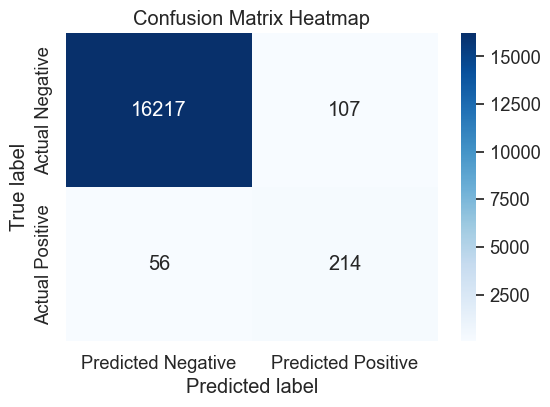

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming the confusion matrix and other metrics are already computed
conf_matrix = np.array([[16217  , 107],[56,214]])

# Plotting confusion matrix heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size here
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()


# XGBOOST (Random Undersampling, 20x Minority Class Weight)

In [92]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from jddb.performance import Result, Report
from jddb.file_repo import FileRepo

# %% define function to build model specific data
def matrix_build(shot_list, file_repo, tags):
    """
    get x and y from file_repo by shots and tags
    Args:
        shot_list: shots for data matrix
        file_repo:
        tags: tags from file_repo

    Returns: matrix of x and y
    """
    x_set = np.empty([0, len(tags) - 1])
    y_set = np.empty([0])
    for shot in shot_list:
        shot = int(shot)
        x_data = file_repo.read_data(shot, tags)
        y_data = file_repo.read_data(shot, ['alarm_tag'])
        x_data.pop('alarm_tag', None)
        res = np.array(list(x_data.values())).T
        res_y = np.array(list(y_data.values())).T.flatten()
        x_set = np.append(x_set, res, axis=0)
        y_set = np.append(y_set, res_y, axis=0)
    return x_set, y_set

# init FileRepo
test_file_repo = FileRepo(r"./JDDB_repo_2A_processed")
test_shot_list = test_file_repo.get_all_shots()
print(len(test_shot_list))
tag_list = test_file_repo.get_tag_list(test_shot_list[0])
# disruption tag for dataset split
is_disrupt = []
for shot in test_shot_list:
    dis_label = test_file_repo.read_labels(shot, ['IsDisrupt'])
    is_disrupt.append(dis_label['IsDisrupt'])

# train test split on shot not sample according to whether shots are disruption
# set test_size=0.5 to get 50% shots as test set
train_shots, test_shots, _, _ = train_test_split(
    test_shot_list, is_disrupt, test_size=0.5,
    random_state=1, shuffle=True, stratify=is_disrupt)

# create x and y matrix for ML models
X_train, y_train = matrix_build(train_shots, test_file_repo, tag_list)
X_test, y_test = matrix_build(test_shots, test_file_repo, tag_list)

# Apply Random Undersampling to the training data
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Initialize XGBoost classifier with increased weights for minority class
clf = XGBClassifier(objective='binary:logistic', random_state=0, n_jobs=-1, scale_pos_weight=0.07)

# Measure time for training
start_time = time.time()
clf.fit(X_resampled, y_resampled)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Make predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))


22
Training time: 0.07 seconds
Confusion Matrix:
[[16217   107]
 [   56   214]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     16324
         1.0       0.67      0.79      0.72       270

    accuracy                           0.99     16594
   macro avg       0.83      0.89      0.86     16594
weighted avg       0.99      0.99      0.99     16594


ROC AUC Score:
0.9944779102797972


# Decision Tree (SMOTEENN + Minority class Weight)

In [38]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.combine import SMOTEENN
from jddb.performance import Result, Report
from jddb.file_repo import FileRepo

# Function to build model specific data
def matrix_build(shot_list, file_repo, tags):
    """
    Get x and y from file_repo by shots and tags
    Args:
        shot_list: shots for data matrix
        file_repo:
        tags: tags from file_repo

    Returns: matrix of x and y
    """
    x_set = np.empty([0, len(tags) - 1])
    y_set = np.empty([0])
    for shot in shot_list:
        shot = int(shot)
        x_data = file_repo.read_data(shot, tags)
        y_data = file_repo.read_data(shot, ['alarm_tag'])
        x_data.pop('alarm_tag', None)
        res = np.array(list(x_data.values())).T
        res_y = np.array(list(y_data.values())).T.flatten()
        x_set = np.append(x_set, res, axis=0)
        y_set = np.append(y_set, res_y, axis=0)
    return x_set, y_set

# Initialize FileRepo
test_file_repo = FileRepo(r"./JDDB_repo_2A_processed")
test_shot_list = test_file_repo.get_all_shots()
print(len(test_shot_list))
tag_list = test_file_repo.get_tag_list(test_shot_list[0])

# Disruption tag for dataset split
is_disrupt = []
for shot in test_shot_list:
    dis_label = test_file_repo.read_labels(shot, ['IsDisrupt'])
    is_disrupt.append(dis_label['IsDisrupt'])

# Train-test split on shot, not sample, according to whether shots are disruptions
# Set test_size=0.5 to get 50% shots as the test set
train_shots, test_shots, _, _ = train_test_split(
    test_shot_list, is_disrupt, test_size=0.5,
    random_state=1, shuffle=True, stratify=is_disrupt)

# Create x and y matrix for ML models
X_train, y_train = matrix_build(train_shots, test_file_repo, tag_list)
X_test, y_test = matrix_build(test_shots, test_file_repo, tag_list)

# Apply SMOTEENN to the training data
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Define class weights (example: increase weight of minority class)
class_weights = {0: 1, 1: 0.1}  # Adjust as needed

# Initialize Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=0, class_weight=class_weights)

# Train the Decision Tree Classifier
clf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))


22
Confusion Matrix:
[[15958   366]
 [   90   180]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     16324
         1.0       0.33      0.67      0.44       270

    accuracy                           0.97     16594
   macro avg       0.66      0.82      0.71     16594
weighted avg       0.98      0.97      0.98     16594


ROC AUC Score:
0.8221228457077513


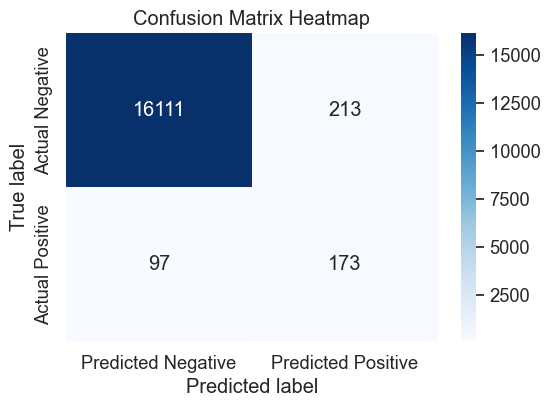

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming the confusion matrix and other metrics are already computed
conf_matrix = np.array([[16111, 213],
                        [97, 173]])

# Plotting confusion matrix heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size here
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()


# Random Forest (ADASYN Over-Sampling)

In [25]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import ADASYN
from jddb.performance import Result, Report
from jddb.file_repo import FileRepo

# Define function to build model specific data
def matrix_build(shot_list, file_repo, tags):
    """
    get x and y from file_repo by shots and tags
    Args:
        shot_list: shots for data matrix
        file_repo:
        tags: tags from file_repo

    Returns: matrix of x and y
    """
    x_set = np.empty([0, len(tags) - 1])
    y_set = np.empty([0])
    for shot in shot_list:
        shot = int(shot)
        x_data = file_repo.read_data(shot, tags)
        y_data = file_repo.read_data(shot, ['alarm_tag'])
        x_data.pop('alarm_tag', None)
        res = np.array(list(x_data.values())).T
        res_y = np.array(list(y_data.values())).T.flatten()
        x_set = np.append(x_set, res, axis=0)
        y_set = np.append(y_set, res_y, axis=0)
    return x_set, y_set

# Initialize FileRepo
test_file_repo = FileRepo(r"./JDDB_repo_2A_processed")
test_shot_list = test_file_repo.get_all_shots()
print(len(test_shot_list))
tag_list = test_file_repo.get_tag_list(test_shot_list[0])

# Disruption tag for dataset split
is_disrupt = []
for shot in test_shot_list:
    dis_label = test_file_repo.read_labels(shot, ['IsDisrupt'])
    is_disrupt.append(dis_label['IsDisrupt'])

# Train test split on shot not sample according to whether shots are disruption
# Set test_size=0.5 to get 50% shots as test set
train_shots, test_shots, _, _ = train_test_split(test_shot_list, is_disrupt, test_size=0.5, random_state=1, shuffle=True, stratify=is_disrupt)

# Create x and y matrix for ML models
X_train, y_train = matrix_build(train_shots, test_file_repo, tag_list)
X_test, y_test = matrix_build(test_shots, test_file_repo, tag_list)

# Apply ADASYN to the training data
adasyn = ADASYN(random_state=0)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Define class weights (example: increase weight of minority class)
class_weights = {0: 1, 1: 0.1}  # Adjust as needed

# Initialize Random Forest Classifier
clf = RandomForestClassifier(random_state=0, class_weight=class_weights)

# Train the classifier
clf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))


22
Confusion Matrix:
[[16195   129]
 [   99   171]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     16324
         1.0       0.57      0.63      0.60       270

    accuracy                           0.99     16594
   macro avg       0.78      0.81      0.80     16594
weighted avg       0.99      0.99      0.99     16594


ROC AUC Score:
0.9916223102543856


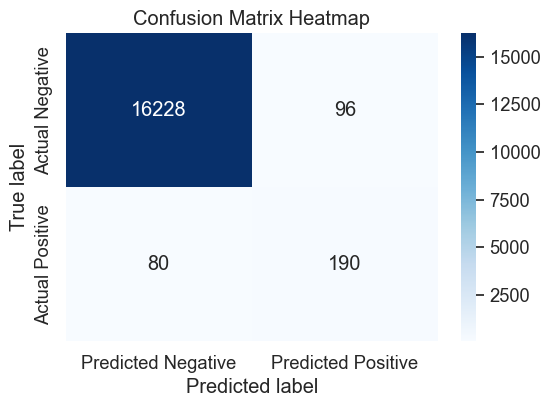

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix values
conf_matrix = np.array([[16228   , 96],
 [   80 ,  190]])

# Plotting confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()


# KNN (Random Undersampling)

In [34]:
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from jddb.performance import Result, Report
from jddb.file_repo import FileRepo

# %% define function to build model specific data
def matrix_build(shot_list, file_repo, tags):
    """
    get x and y from file_repo by shots and tags
    Args:
        shot_list: shots for data matrix
        file_repo:
        tags: tags from file_repo

    Returns: matrix of x and y
    """
    x_set = np.empty([0, len(tags) - 1])
    y_set = np.empty([0])
    for shot in shot_list:
        shot = int(shot)
        x_data = file_repo.read_data(shot, tags)
        y_data = file_repo.read_data(shot, ['alarm_tag'])
        x_data.pop('alarm_tag', None)
        res = np.array(list(x_data.values())).T
        res_y = np.array(list(y_data.values())).T.flatten()
        x_set = np.append(x_set, res, axis=0)
        y_set = np.append(y_set, res_y, axis=0)
    return x_set, y_set

# init FileRepo
test_file_repo = FileRepo(r"./JDDB_repo_2A_processed")
test_shot_list = test_file_repo.get_all_shots()
print(len(test_shot_list))
tag_list = test_file_repo.get_tag_list(test_shot_list[0])

# disruption tag for dataset split
is_disrupt = []
for shot in test_shot_list:
    dis_label = test_file_repo.read_labels(shot, ['IsDisrupt'])
    is_disrupt.append(dis_label['IsDisrupt'])

# train test split on shot not sample according to whether shots are disruption
# set test_size=0.5 to get 50% shots as test set
train_shots, test_shots, _, _ = train_test_split(test_shot_list, is_disrupt, test_size=0.5, random_state=1, shuffle=True, stratify=is_disrupt)

# create x and y matrix for ML models
X_train, y_train = matrix_build(train_shots, test_file_repo, tag_list)
X_test, y_test = matrix_build(test_shots, test_file_repo, tag_list)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize KNN classifier
clf = KNeighborsClassifier(n_neighbors=5)

# Train the model
start_time = time.time()
clf.fit(X_train_scaled, y_train)
end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Make predictions
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

22
Training time: 0.00 seconds
Confusion Matrix:
[[16172   152]
 [   75   195]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     16324
         1.0       0.56      0.72      0.63       270

    accuracy                           0.99     16594
   macro avg       0.78      0.86      0.81     16594
weighted avg       0.99      0.99      0.99     16594


ROC AUC Score:
0.8913088658371677


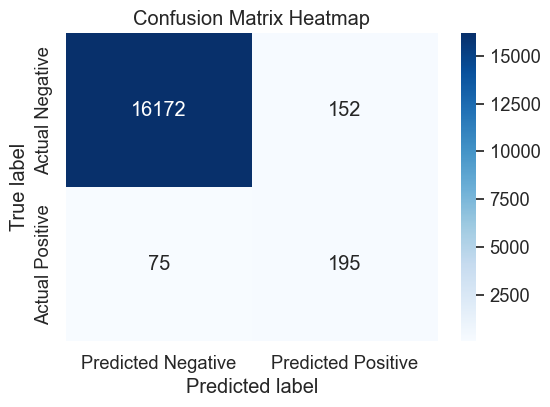

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Confusion matrix values
conf_matrix = np.array([[16172  , 152],
 [   75  , 195]])

# Plotting confusion matrix heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size here
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()


# SVM (Processing cap)

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from jddb.performance import Result, Report
from jddb.file_repo import FileRepo

# Function to build model specific data
def matrix_build(shot_list, file_repo, tags):
    """
    Get x and y from file_repo by shots and tags
    Args:
        shot_list: shots for data matrix
        file_repo:
        tags: tags from file_repo

    Returns: matrix of x and y
    """
    x_set = np.empty([0, len(tags) - 1])
    y_set = np.empty([0])
    for shot in shot_list:
        shot = int(shot)
        x_data = file_repo.read_data(shot, tags)
        y_data = file_repo.read_data(shot, ['alarm_tag'])
        x_data.pop('alarm_tag', None)
        res = np.array(list(x_data.values())).T
        res_y = np.array(list(y_data.values())).T.flatten()
        x_set = np.append(x_set, res, axis=0)
        y_set = np.append(y_set, res_y, axis=0)
    return x_set, y_set

# Initialize FileRepo
test_file_repo = FileRepo(r"./JDDB_repo_2A_processed")
test_shot_list = test_file_repo.get_all_shots()
print(len(test_shot_list))
tag_list = test_file_repo.get_tag_list(test_shot_list[0])

# Disruption tag for dataset split
is_disrupt = []
for shot in test_shot_list:
    dis_label = test_file_repo.read_labels(shot, ['IsDisrupt'])
    is_disrupt.append(dis_label['IsDisrupt'])

# Train-test split on shot, not sample, according to whether shots are disruptions
# Set test_size=0.2 to get 20% shots as the test set
train_shots, test_shots, _, _ = train_test_split(
    test_shot_list, is_disrupt, test_size=0.2,
    random_state=1, shuffle=True, stratify=is_disrupt)

# Create x and y matrix for ML models
X_train, y_train = matrix_build(train_shots, test_file_repo, tag_list)
X_test, y_test = matrix_build(test_shots, test_file_repo, tag_list)

# Apply SMOTEENN to the training data
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Define class weights (example: increase weight of minority class)
class_weights = {0: 1, 1: 100}  # Adjust as needed

# Define sample weights based on class weights
sample_weights = np.array([class_weights[y] for y in y_resampled])

# Initialize SVM classifier
clf = SVC(probability=True, random_state=0)

# Measure time for training
start_time = time.time()
# Train SVM with sample weights
clf.fit(X_resampled, y_resampled, sample_weight=sample_weights)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

# Make predictions on the test set
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))


22


In [ ]:
from sklearn.metrics import confusion_matrix
# %% plot some of the result: confusion matrix
matrix = confusion_matrix(shots_true_disruption, shots_pred_disruption)
sns.heatmap(matrix, annot=True, cmap="Blues", fmt='.0f')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
# plt.savefig(os.path.join('..//_temp_test//', 'Confusion Matrix.png'), dpi=300)
plt.show()